# Hyperparameter Optimization for Sleep Stage Classification

This notebook focuses on optimizing machine learning models to improve precision for **Stage 0 (Wake)**, **Stage 1 (N1)**, and **Stage 2 (N2)**. These stages are critical for the smart alarm application.

We will use `GridSearchCV` and `RandomizedSearchCV` to tune hyperparameters, with a strong emphasis on `class_weight` to handle class imbalance and penalize false positives for our target stages.

In [2]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Ensure models directory exists
models_dir = "saved_models_optimized"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [3]:
# Load Data
# Assuming the data is in the same location as the previous notebook
df = pd.read_csv("data/bigboy.csv")

# Preprocessing
# Updated to include new HR features (std and mean)
x = df[['cosine_feature', 'count_feature', 'hr_std', 'hr_mean', 'time_feature']]
y = df['psg_label']

# Remap label 5 (REM) to 4 if necessary, or keep as is if your pipeline expects 0-4
# Based on previous notebook, 5 was replaced with 4.
y.replace({5: 4}, inplace=True)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training samples: {x_train.shape[0]}")
print(f"Testing samples: {x_test.shape[0]}")
print(f"Class distribution:\n{y.value_counts().sort_index()}")

Training samples: 18293
Testing samples: 4574
Class distribution:
psg_label
0     1907
1     1475
2    11203
3     3252
4     5030
Name: count, dtype: int64


In [4]:
# Define Custom Scorer
# We want to maximize the average precision of classes 0, 1, and 2.

def custom_precision_scorer(y_true, y_pred):
    # Calculate precision for each class
    # labels=[0, 1, 2] ensures we only look at these classes
    # average='macro' calculates the mean of the per-class precisions
    return precision_score(y_true, y_pred, labels=[0, 1, 2], average='macro', zero_division=0)

# Create the scorer object for GridSearchCV
target_scorer = make_scorer(custom_precision_scorer)

print("Custom scorer defined: Maximizes Macro Precision for Stages 0, 1, and 2.")

Custom scorer defined: Maximizes Macro Precision for Stages 0, 1, and 2.


In [5]:
# Define Class Weights
# Strategy: Penalize mistakes on Deep Sleep (3) and REM (4) heavily to force the model
# to be precise when predicting Light Sleep (0, 1, 2).
# Or, balance the classes to handle the rarity of N1.

custom_weights_1 = {
    0: 1, 
    1: 2, # Boost N1 importance (rare class)
    2: 1, 
    3: 2, # Penalize Deep Sleep errors (to improve Light Sleep precision)
    4: 1
}

custom_weights_2 = {
    0: 1, 
    1: 3, # Heavily boost N1
    2: 1, 
    3: 3, # Heavily penalize Deep Sleep errors
    4: 1
}

# NEW: Aggressive N1 Focus
custom_weights_3 = {
    0: 1, 
    1: 6, # Super aggressive boost for N1 (Prioritize waking up in N1)
    2: 1, 
    3: 3, # Keep Deep Sleep penalty high
    4: 1
}

# Grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 10]
}

# Grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8],
    'min_samples_leaf': [1, 4]
}

# Grid for Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

# Grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 11, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [6]:
# Optimization Function
from sklearn.utils.class_weight import compute_sample_weight

def optimize_model(name, model, param_grid, X, y, sample_weight=None):
    print(f"Optimizing {name}...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring=target_scorer,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=10 # Keep low to prevent crash
    )
    
    if sample_weight is not None:
        search.fit(X, y, sample_weight=sample_weight)
    else:
        search.fit(X, y)
    
    print(f"Best Parameters for {name}: {search.best_params_}")
    print(f"Best Score (Avg Precision 0,1,2): {search.best_score_:.4f}")
    
    return search.best_estimator_

# --- Define Weight Configurations ---
weight_configs = [
    ("Balanced", "balanced", None), # Name, class_weight param, sample_weight (computed later if needed)
    # ("Weights 2", custom_weights_2, custom_weights_2),
    # ("Weights 3", custom_weights_3, custom_weights_3)
]

# Dictionary to store all optimized models
optimized_models = {}

# --- Random Forest ---
for w_name, w_param, _ in weight_configs:
    model_name = f"Random Forest ({w_name})"
    # Set class_weight in the constructor
    rf = RandomForestClassifier(random_state=42, class_weight=w_param)
    optimized_models[model_name] = optimize_model(model_name, rf, rf_param_grid, x_train, y_train)

# --- XGBoost ---
# XGBoost needs sample_weights
for w_name, _, w_dict in weight_configs:
    model_name = f"XGBoost ({w_name})"
    
    # Compute sample weights
    if w_name == "Balanced":
        s_weights = compute_sample_weight("balanced", y_train)
    else:
        s_weights = compute_sample_weight(w_dict, y_train)
        
    xgb = XGBClassifier(random_state=42, eval_metric='mlogloss', device='cuda', tree_method='hist')
    optimized_models[model_name] = optimize_model(model_name, xgb, xgb_param_grid, x_train, y_train, sample_weight=s_weights)

# --- Gradient Boosting ---
# Gradient Boosting needs sample_weights
for w_name, _, w_dict in weight_configs:
    model_name = f"Gradient Boosting ({w_name})"
    
    if w_name == "Balanced":
        s_weights = compute_sample_weight("balanced", y_train)
    else:
        s_weights = compute_sample_weight(w_dict, y_train)
        
    gb = GradientBoostingClassifier(random_state=42)
    optimized_models[model_name] = optimize_model(model_name, gb, gb_param_grid, x_train, y_train, sample_weight=s_weights)

Optimizing Random Forest (Balanced)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for Random Forest (Balanced): {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 30}
Best Score (Avg Precision 0,1,2): 0.6568
Optimizing XGBoost (Balanced)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\sklearn\model_selection\_search.py:881: UserWarning: The scoring make_scorer(custom_precision_scorer, response_method='predict') does not support sample_weight, which may lead to statistically incorrect results when fitting RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gam

Best Parameters for XGBoost (Balanced): {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best Score (Avg Precision 0,1,2): 0.6375
Optimizing Gradient Boosting (Balanced)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\sklearn\model_selection\_search.py:881: UserWarning: The scoring make_scorer(custom_precision_scorer, response_method='predict') does not support sample_weight, which may lead to statistically incorrect results when fitting RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20, n_jobs=10,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 8],
                                        'min_samples_leaf': [1, 4],
                                        'n_estimators': [100, 200]},
                   random_state=42,
                   scoring=make_scorer(custom_precision_scorer, response_method='predict'),
                   verbose=1) with sample_weight. 
  warnings.warn(


Best Parameters for Gradient Boosting (Balanced): {'n_estimators': 200, 'min_samples_leaf': 4, 'max_depth': 8, 'learning_rate': 0.2}
Best Score (Avg Precision 0,1,2): 0.6212


In [7]:
# Optimize Logistic Regression and KNN

# --- Logistic Regression ---
for w_name, w_param, _ in weight_configs:
    model_name = f"Logistic Regression ({w_name})"
    lr = LogisticRegression(max_iter=2000, random_state=42, class_weight=w_param)
    optimized_models[model_name] = optimize_model(model_name, lr, lr_param_grid, x_train, y_train)

# --- KNN ---
# KNN does not support class weights in the same way. We will optimize it once.
optimized_models["KNN"] = optimize_model("KNN", KNeighborsClassifier(), knn_param_grid, x_train, y_train)

Optimizing Logistic Regression (Balanced)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for Logistic Regression (Balanced): {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}
Best Score (Avg Precision 0,1,2): 0.4522
Optimizing KNN...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for KNN: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}
Best Score (Avg Precision 0,1,2): 0.5889


In [8]:
# Optimize Neural Network (MLP)
from sklearn.neural_network import MLPClassifier

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# --- MLP Classifier ---
# MLP supports sample_weight in fit()
for w_name, _, w_dict in weight_configs:
    model_name = f"MLP ({w_name})"
    
    if w_name == "Balanced":
        s_weights = compute_sample_weight("balanced", y_train)
    else:
        s_weights = compute_sample_weight(w_dict, y_train)
        
    mlp = MLPClassifier(max_iter=1000, random_state=42)
    optimized_models[model_name] = optimize_model(model_name, mlp, mlp_param_grid, x_train, y_train, sample_weight=s_weights)

Optimizing MLP (Balanced)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\sklearn\model_selection\_search.py:881: UserWarning: The scoring make_scorer(custom_precision_scorer, response_method='predict') does not support sample_weight, which may lead to statistically incorrect results when fitting RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(max_iter=1000, random_state=42),
                   n_iter=20, n_jobs=10,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50),
                                                               (100, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam'

Best Parameters for MLP (Balanced): {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Best Score (Avg Precision 0,1,2): 0.5130



--- Final Evaluation on Test Set ---


c:\Users\Kaito\Desktop\actually-good-alarm\venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [12:14:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
C:\Users\Kaito\AppData\Local\Temp\ipykernel_11676\2020958611.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Macro Precision (0,1,2)", data=results_df, palette="viridis")
C:\Users\Kaito\AppData\Local\Temp\ipykernel_11676\202095861

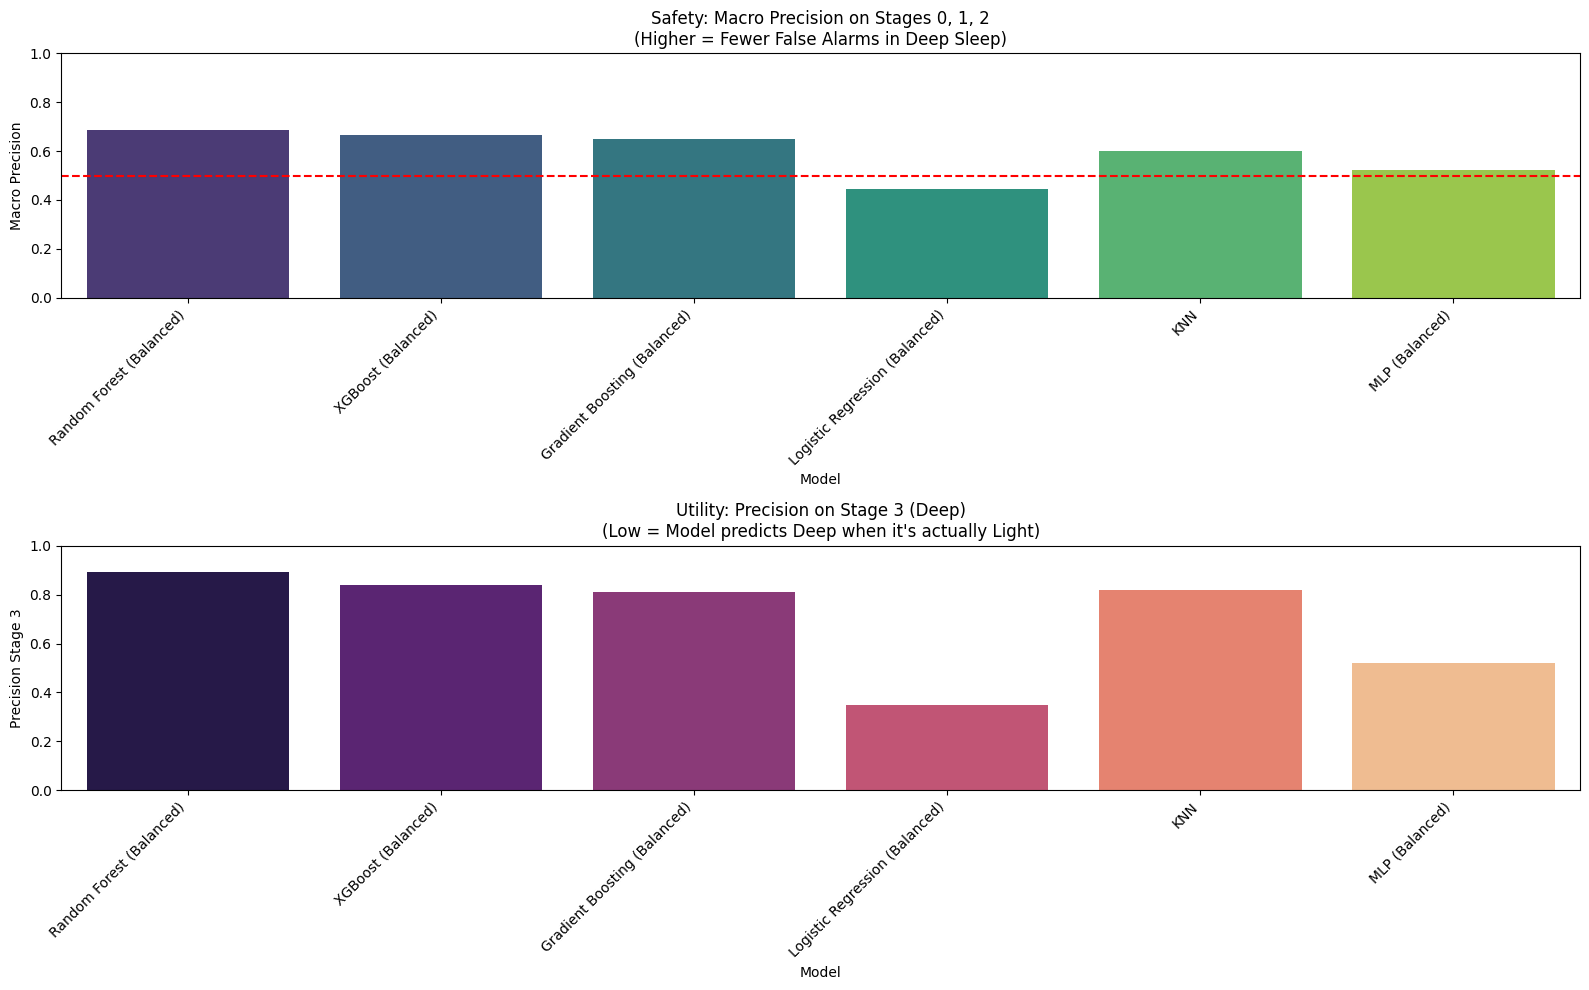

,Model,"Macro Precision (0,1,2)",Precision 0 (Wake),Precision 1 (N1),Precision 2 (N2),Precision 3 (Deep),Recall 0 (Wake),Recall 1 (N1),Recall 2 (N2),Recall 3 (Deep),Accuracy
0,Random Forest (Balanced),0.685182,0.768595,0.464286,0.822666,0.891892,0.711735,0.221843,0.911061,0.811060,0.824443
1,XGBoost (Balanced),0.665258,0.745050,0.390152,0.860572,0.839763,0.767857,0.351536,0.841535,0.869432,0.813293
2,Gradient Boosting (Balanced),0.649235,0.761780,0.355372,0.830554,0.809451,0.742347,0.293515,0.832054,0.815668,0.792960
3,Logistic Regression (Balanced),0.443482,0.414141,0.213333,0.702970,0.348169,0.418367,0.273038,0.384650,0.745008,0.484915
4,KNN,0.601539,0.691460,0.293333,0.819824,0.817896,0.640306,0.225256,0.840181,0.800307,0.777438
5,MLP (Balanced),0.521756,0.553753,0.195540,0.815975,0.519958,0.696429,0.389078,0.470429,0.760369,0.588981


In [10]:
# Compare All Optimized Models
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# optimized_models dictionary is already populated in previous cells

results_list = []

print("\n--- Final Evaluation on Test Set ---")
for name, model in optimized_models.items():
    y_pred = model.predict(x_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Precision for target classes (0, 1, 2)
    prec_0 = report['0']['precision']
    prec_1 = report['1']['precision']
    prec_2 = report['2']['precision']
    
    # Check N3 (Deep Sleep) metrics
    prec_3 = report['3']['precision']

    # recall 
    rec_0 = report['0']['recall']
    rec_1 = report['1']['recall']
    rec_2 = report['2']['recall']
    rec_3 = report['3']['recall']
    
    macro_prec_012 = (prec_0 + prec_1 + prec_2) / 3
    
    results_list.append({
        "Model": name,
        "Macro Precision (0,1,2)": macro_prec_012,
        "Precision 0 (Wake)": prec_0,
        "Precision 1 (N1)": prec_1,
        "Precision 2 (N2)": prec_2,
        "Precision 3 (Deep)": prec_3,
        "Recall 0 (Wake)": rec_0,
        "Recall 1 (N1)": rec_1,
        "Recall 2 (N2)": rec_2,
        "Recall 3 (Deep)": rec_3,
        "Accuracy": report['accuracy']
    })
    
    # print(f"{name}: Macro Prec (0,1,2)={macro_prec_012:.4f}, Prec N3={prec_3:.4f}, Recall N1={recall_1:.4f}")

# Create DataFrame for plotting
results_df = pd.DataFrame(results_list)

# Sort by Macro Precision for better visualization
# results_df = results_df.sort_values("Macro Precision (0,1,2)", ascending=False)

# Plotting
plt.figure(figsize=(16, 10))

# Plot Macro Precision (Safety)
plt.subplot(2, 1, 1)
sns.barplot(x="Model", y="Macro Precision (0,1,2)", data=results_df, palette="viridis")
plt.title("Safety: Macro Precision on Stages 0, 1, 2\n(Higher = Fewer False Alarms in Deep Sleep)")
plt.ylabel("Macro Precision")
plt.ylim(0, 1)
plt.axhline(y=0.5, color='r', linestyle='--', label="Baseline")
plt.xticks(rotation=45, ha='right')

# Plot Precision N3 (Utility)
plt.subplot(2, 1, 2)
sns.barplot(x="Model", y="Precision 3 (Deep)", data=results_df, palette="magma")
plt.title("Utility: Precision on Stage 3 (Deep)\n(Low = Model predicts Deep when it's actually Light)")
plt.ylabel("Precision Stage 3")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

display(results_df)

,Model,N1_true_count,pred_0_count,pred_0_prop,pred_1_count,pred_1_prop,pred_2_count,pred_2_prop,pred_3_count,pred_3_prop,pred_4_count,pred_4_prop,top_pred,top_pred_prop
5,XGBoost (Weights 3),293,6,0.020478,181,0.617747,58,0.197952,25,0.085324,23,0.078498,1,0.617747
15,MLP (Weights 3),293,4,0.013652,175,0.597270,64,0.218430,17,0.058020,33,0.112628,1,0.597270
8,Gradient Boosting (Weights 3),293,7,0.023891,173,0.590444,70,0.238908,20,0.068259,23,0.078498,1,0.590444
11,Logistic Regression (Weights 3),293,3,0.010239,128,0.436860,112,0.382253,41,0.139932,9,0.030717,1,0.436860
14,MLP (Weights 2),293,16,0.054608,120,0.409556,87,0.296928,26,0.088737,44,0.150171,1,0.409556
13,MLP (Balanced),293,55,0.187713,111,0.378840,27,0.092150,18,0.061433,82,0.279863,1,0.378840
7,Gradient Boosting (Weights 2),293,28,0.095563,102,0.348123,111,0.378840,24,0.081911,28,0.095563,2,0.378840
4,XGBoost (Weights 2),293,20,0.068259,101,0.344710,115,0.392491,22,0.075085,35,0.119454,2,0.392491
6,Gradient Boosting (Balanced),293,50,0.170648,91,0.310580,75,0.255973,19,0.064846,58,0.197952,1,0.310580
1,Random Forest (Weights 2),293,26,0.088737,88,0.300341,115,0.392491,14,0.047782,50,0.170648,2,0.392491


Saved N1 prediction distribution to: saved_models_optimized\n1_prediction_distribution.csv


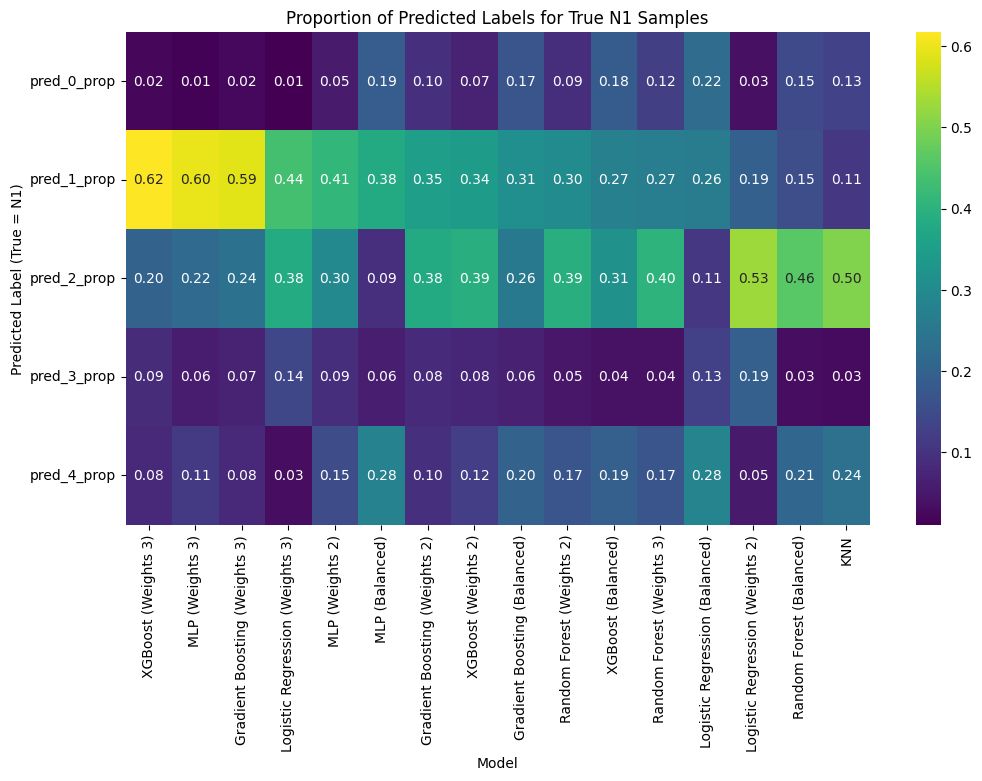

In [32]:
# Analyze what models predict when the true label is N1 (label == 1)
import os

n1_mask = (y_test == 1)
if n1_mask.sum() == 0:
    print("No N1 samples in the test set.")
else:
    n1_results = []
    all_labels = [0, 1, 2, 3, 4]

    for name, model in optimized_models.items():
        preds = model.predict(x_test[n1_mask])
        counts = np.bincount(preds, minlength=len(all_labels))
        props = counts / counts.sum()

        row = {
            'Model': name,
            'N1_true_count': int(counts.sum()),
            'top_pred': int(np.argmax(counts)),
            'top_pred_prop': float(np.max(props))
        }

        for lab in all_labels:
            row[f'pred_{lab}_count'] = int(counts[lab])
            row[f'pred_{lab}_prop'] = float(props[lab])

        n1_results.append(row)

    n1_df = pd.DataFrame(n1_results)
    # Sort by proportion the model assigns to their top prediction (or by pred_1_prop if you prefer)
    n1_df = n1_df.sort_values('pred_1_prop', ascending=False)

    # Display a compact table with counts and percentages
    display_cols = [
        'Model', 'N1_true_count',
        'pred_0_count', 'pred_0_prop',
        'pred_1_count', 'pred_1_prop',
        'pred_2_count', 'pred_2_prop',
        'pred_3_count', 'pred_3_prop',
        'pred_4_count', 'pred_4_prop',
        'top_pred', 'top_pred_prop'
    ]

    display(n1_df[display_cols])

    # Save results
    save_dir = globals().get('models_dir', 'saved_models_optimized')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    csv_path = os.path.join(save_dir, 'n1_prediction_distribution.csv')
    n1_df.to_csv(csv_path, index=False)
    print(f"Saved N1 prediction distribution to: {csv_path}")

    # Heatmap of proportions
    plt.figure(figsize=(12, max(4, len(n1_df) * 0.4)))
    prop_cols = [f'pred_{lab}_prop' for lab in all_labels]
    heat_df = n1_df.set_index('Model')[prop_cols]
    sns.heatmap(heat_df.T, annot=True, fmt='.2f', cmap='viridis')
    plt.title('Proportion of Predicted Labels for True N1 Samples')
    plt.yticks(rotation=0)
    plt.xlabel('Model')
    plt.ylabel('Predicted Label (True = N1)')
    plt.show()

In [1]:
# --- Smart Post-Processing Filter ---
# Goal: Smooth out N1 noise (likely errors) while PRESERVING short Wake arousals (real events).

def smart_sleep_filter(predictions):
    """
    Applies a rule-based filter:
    1. If N1 is detected, check neighbors. If surrounded by N2/N3, correct it.
    2. If Wake (0) is detected, KEEP IT (unless it's a single blip in Deep Sleep, maybe).
    """
    filtered = predictions.copy()
    n = len(predictions)
    
    # Iterate through the night (skip first and last for simplicity)
    for i in range(1, n - 1):
        current = predictions[i]
        prev = predictions[i-1]
        next_val = predictions[i+1]
        
        # Rule 1: N1 Smoothing
        # If we are N1, but neighbors are identical and NOT N1 (e.g., N2 -> N1 -> N2)
        if current == 1:
            if prev == next_val and prev != 1:
                filtered[i] = prev
            # Or if neighbors are different but both "Deep" (e.g., N2 -> N1 -> N3)
            elif (prev in [2, 3]) and (next_val in [2, 3]):
                filtered[i] = prev # Default to previous state
                
        # Rule 2: Wake Preservation
        # We generally TRUST Wake predictions because arousals are short.
        # However, if we have N3 -> Wake -> N3 (1 epoch), it might be an artifact.
        # But for now, let's be safe and NOT filter Wake.
        
    return filtered

# Select the best model
best_model_name = "Random Forest (Weights 2)"
if best_model_name in optimized_models:
    best_model = optimized_models[best_model_name]
    y_pred_raw = best_model.predict(x_test)
    
    # Apply Smart Filter
    y_pred_smart = smart_sleep_filter(y_pred_raw)
    
    print(f"--- Effect of Smart Filter on {best_model_name} ---")
    
    # Compare Precision for N1
    prec_raw = precision_score(y_test, y_pred_raw, labels=[1], average='macro', zero_division=0)
    prec_smart = precision_score(y_test, y_pred_smart, labels=[1], average='macro', zero_division=0)
    
    # Compare Recall for N1
    rec_raw = recall_score(y_test, y_pred_raw, labels=[1], average='macro', zero_division=0)
    rec_smart = recall_score(y_test, y_pred_smart, labels=[1], average='macro', zero_division=0)
    
    print(f"N1 Precision: {prec_raw:.4f} -> {prec_smart:.4f}")
    print(f"N1 Recall:    {rec_raw:.4f} -> {rec_smart:.4f}")
    
    # Check if we accidentally killed Wake (0)
    rec_0_raw = recall_score(y_test, y_pred_raw, labels=[0], average='macro', zero_division=0)
    rec_0_smart = recall_score(y_test, y_pred_smart, labels=[0], average='macro', zero_division=0)
    print(f"Wake Recall:  {rec_0_raw:.4f} -> {rec_0_smart:.4f} (Should be identical or close)")

else:
    print(f"Model {best_model_name} not found.")

NameError: name 'optimized_models' is not defined

In [11]:
# Save Selected Models
import joblib
import os

# Prefer the existing models_dir if present
save_dir = globals().get('models_dir', 'saved_models_optimized')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save ALL optimized models (except Logistic Regression)
print(f"Saving models to {save_dir}...")

for name, model in optimized_models.items():
    if "Logistic Regression" in name:
        print(f"Skipping: {name}")
        continue
        
    try:
        # Sanitize filename
        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "")
        filename = f"{safe_name}_optimized.pkl"
        path = os.path.join(save_dir, filename)
        
        joblib.dump(model, path)
        print(f"Saved: {filename}")
    except Exception as e:
        print(f"Failed to save {name}: {e}")

# Also save the summary results table
try:
    results_csv = os.path.join(save_dir, "optimization_results_summary.csv")
    if 'results_df' in globals():
        results_df.to_csv(results_csv, index=False)
        print(f"Saved results summary to: {results_csv}")
except Exception as e:
    print(f"Failed to save results summary: {e}")

Saving models to saved_models_optimized...
Saved: Random_Forest_Balanced_optimized.pkl
Saved: XGBoost_Balanced_optimized.pkl
Saved: Gradient_Boosting_Balanced_optimized.pkl
Skipping: Logistic Regression (Balanced)
Saved: KNN_optimized.pkl
Saved: MLP_Balanced_optimized.pkl
Saved results summary to: saved_models_optimized\optimization_results_summary.csv
